In [1]:
# pip install --upgrade transformers

In [2]:
import transformers

transformers.__version__

'4.38.0.dev0'

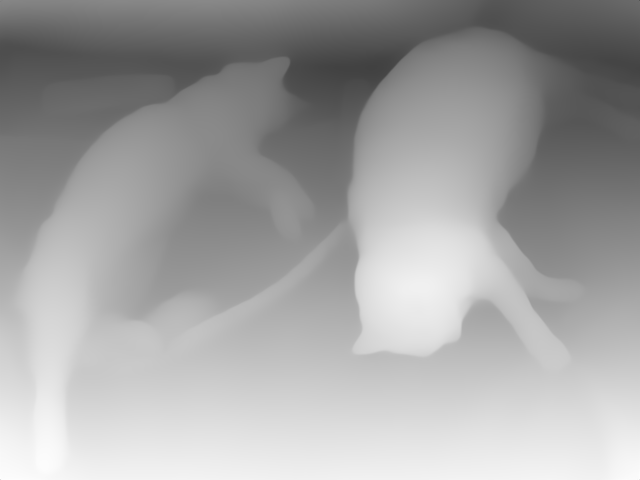

In [3]:
from transformers import pipeline
from PIL import Image
import requests

# load pipe
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

# load image
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# inference
depth = pipe(image)["depth"]
depth


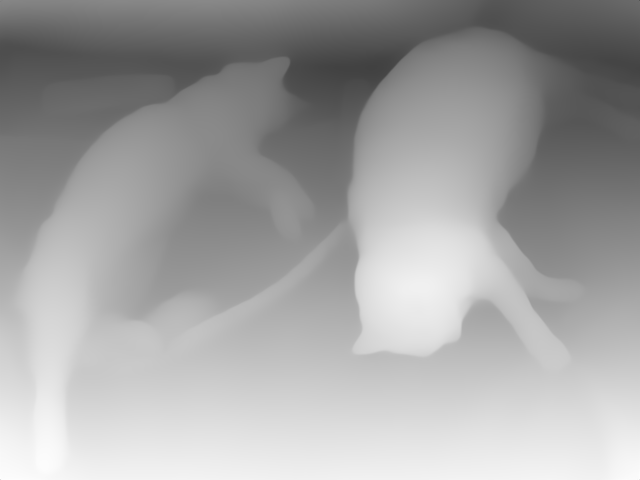

In [3]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth

In [5]:
!pip install -U albumentations 

In [6]:
!pip install datasets

In [4]:
import datasets
from datasets import load_dataset

train_dataset = load_dataset("sayakpaul/nyu_depth_v2", split="train", streaming = True, trust_remote_code=True)
train_dataset.features

{'image': Image(decode=True, id=None),
 'depth_map': Image(decode=True, id=None)}

In [5]:
example = train_dataset.take(5)
example


IterableDataset({
    features: ['image', 'depth_map'],
    n_shards: 12
})

In [6]:
dataset = train_dataset.with_format("torch")
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4, batch_size = 16)

In [7]:
x = next(iter(dataloader))
img = x.get('image')
y = img.size()
y

torch.Size([16, 480, 640, 3])

In [ ]:
# for epoch in range(3):
#     dataset.set_epoch(epoch)
#     for i, batch in enumerate(tqdm(dataloader, total=5)):
#         if i == 5:
#             break
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         loss = outputs[0]
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         if i % 10 == 0:
#             print(f"loss: {loss}")

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
# prepare image for the model
for i, batch in enumerate(tqdm(dataloader)):
    image = batch.get('image')
#     print(image)
    inputs = image_processor(images=image, return_tensors="pt")
#     print(inputs.values())
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size= [image.size()[1], image.size()[2]],#image.size(),
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    output = prediction.squeeze().cpu().numpy()
    print(output)
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted[0])
    plt.imshow(depth)
    